In [9]:
!pip install statsmodels


In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [11]:
df = pd.read_csv("/workspaces/Generative-AI/Nat_Gas.csv")
df.columns = ["date", "price"]
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")
df = df.asfreq("M")


/tmp/ipykernel_7507/1342212730.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"])
/tmp/ipykernel_7507/1342212730.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq("M")


In [12]:
stl = STL(df["price"], period=12, robust=True)
res = stl.fit()

trend = res.trend
seasonal = res.seasonal


In [13]:
model = SARIMAX(
    trend,
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
forecast = results.get_forecast(steps=12)
trend_forecast = forecast.predicted_mean


In [18]:
def estimate_gas_price(date):
    date = pd.to_datetime(date)

    # Convert to month-end (KEY FIX)
    month_end = date.to_period("M").to_timestamp("M")

    # Historical
    if month_end <= df.index[-1]:
        return round(float(
            trend.loc[month_end] + seasonal.loc[month_end]
        ), 3)

    # Future (up to 1 year)
    months_ahead = (month_end.to_period("M") - df.index[-1].to_period("M")).n
    if months_ahead > 12:
        raise ValueError("Only 1-year extrapolation supported")

    seasonal_adj = seasonal.iloc[month_end.month - 1]
    price = trend_forecast.iloc[months_ahead - 1] + seasonal_adj

    return round(float(price), 3)


In [19]:
estimate_gas_price("2022-12-15")  # ✅ works
estimate_gas_price("2024-06-10")  # ✅ works
estimate_gas_price("2025-03-15")  # ✅ works


14.588

In [21]:
# Create future forecast dates (1 year)
future_dates = pd.date_range(
    start=df.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq="M"
)

# Generate forecast prices
future_prices = []
for i, d in enumerate(future_dates):
    seasonal_adj = seasonal.iloc[d.month - 1]
    price = trend_forecast.iloc[i] + seasonal_adj
    future_prices.append(round(float(price), 3))

# Build future dataframe
future_df = pd.DataFrame({
    "date": future_dates,
    "price": future_prices
})


/tmp/ipykernel_7507/3750214546.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(


In [22]:
final_df = pd.concat([
    df[["price"]].rename(columns={"price": "historical_price"}),
    future_df.set_index("date").rename(columns={"price": "forecast_price"})
])


In [23]:
final_df["final_price"] = final_df["historical_price"].combine_first(
    final_df["forecast_price"]
)


In [24]:
final_df.tail(15)


,historical_price,forecast_price,final_price
date,,,
2024-07-31,11.6,NaN,11.600
2024-08-31,11.5,NaN,11.500
2024-09-30,11.8,NaN,11.800
2024-10-31,NaN,12.064,12.064
2024-11-30,NaN,12.501,12.501
2024-12-31,NaN,12.634,12.634
2025-01-31,NaN,13.264,13.264
2025-02-28,NaN,13.679,13.679
2025-03-31,NaN,14.588,14.588


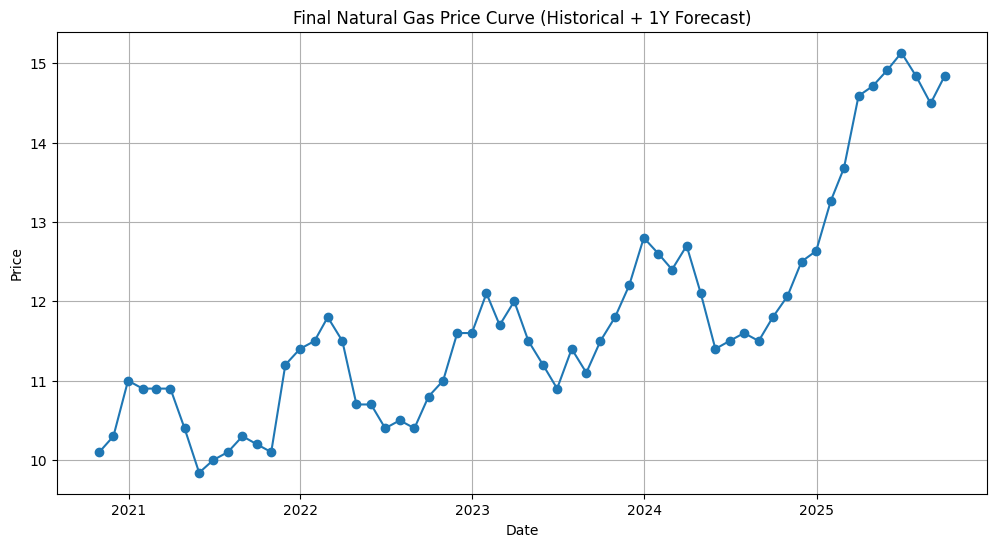

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(final_df.index, final_df["final_price"], marker="o")
plt.title("Final Natural Gas Price Curve (Historical + 1Y Forecast)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()
